In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/gene-expression/data_set_ALL_AML_independent.csv
/kaggle/input/gene-expression/data_set_ALL_AML_train.csv
/kaggle/input/gene-expression/actual.csv


In [2]:
!pip install --upgrade scikit-learn

# ***IMPORT LIBR*ARIES**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB  
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score, precision_score, classification_report, accuracy_score, confusion_matrix, roc_curve, auc,ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
import seaborn as sns


# ***LOAD DATA***

In [4]:
Train_Data = pd.read_csv("../input/gene-expression/data_set_ALL_AML_train.csv")  
Test_Data = pd.read_csv("../input/gene-expression/data_set_ALL_AML_independent.csv")
labels = pd.read_csv("../input/gene-expression/actual.csv", index_col = 'patient') 
Train_Data.head() 

,Gene Description,Gene Accession Number,1,call,2,call.1,3,call.2,4,call.3,...,29,call.33,30,call.34,31,call.35,32,call.36,33,call.37
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-214,A,-139,A,-76,A,-135,A,...,15,A,-318,A,-32,A,-124,A,-135,A
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-153,A,-73,A,-49,A,-114,A,...,-114,A,-192,A,-49,A,-79,A,-186,A
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,-58,A,-1,A,-307,A,265,A,...,2,A,-95,A,49,A,-37,A,-70,A
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,88,A,283,A,309,A,12,A,...,193,A,312,A,230,P,330,A,337,A
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-295,A,-264,A,-376,A,-419,A,...,-51,A,-139,A,-367,A,-188,A,-407,A


In [7]:
Train_Data.head() #38 samples

,Gene Description,Gene Accession Number,1,call,2,call.1,3,call.2,4,call.3,...,29,call.33,30,call.34,31,call.35,32,call.36,33,call.37
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-214,A,-139,A,-76,A,-135,A,...,15,A,-318,A,-32,A,-124,A,-135,A
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-153,A,-73,A,-49,A,-114,A,...,-114,A,-192,A,-49,A,-79,A,-186,A
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,-58,A,-1,A,-307,A,265,A,...,2,A,-95,A,49,A,-37,A,-70,A
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,88,A,283,A,309,A,12,A,...,193,A,312,A,230,P,330,A,337,A
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-295,A,-264,A,-376,A,-419,A,...,-51,A,-139,A,-367,A,-188,A,-407,A


In [8]:
Test_Data.head()   #34 samples  

,Gene Description,Gene Accession Number,39,call,40,call.1,42,call.2,47,call.3,...,65,call.29,66,call.30,63,call.31,64,call.32,62,call.33
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-342,A,-87,A,22,A,-243,A,...,-62,A,-58,A,-161,A,-48,A,-176,A
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-200,A,-248,A,-153,A,-218,A,...,-198,A,-217,A,-215,A,-531,A,-284,A
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,41,A,262,A,17,A,-163,A,...,-5,A,63,A,-46,A,-124,A,-81,A
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,328,A,295,A,276,A,182,A,...,141,A,95,A,146,A,431,A,9,A
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-224,A,-226,A,-211,A,-289,A,...,-256,A,-191,A,-172,A,-496,A,-294,A


# ***DATA PROCESSING***

In [5]:
Test_Data_excluded = Test_Data.iloc[:, 2:] 
patients = [str(i) for i in range(1, 73, 1)]
data_set = pd.concat([Train_Data, Test_Data_excluded], axis=1)[patients]
call_columns = [col for col in data_set.columns if 'call' in col]
data_set = data_set.drop(columns=call_columns)
data_set = data_set.T
data_set["patient"] = pd.to_numeric(patients)
labels["cancer"]= pd.get_dummies(labels.cancer, drop_first=True)  
Data = pd.merge(data_set, labels, on="patient")  
Data.head()

,0,1,2,3,4,5,6,7,8,9,...,7121,7122,7123,7124,7125,7126,7127,7128,patient,cancer
0,-214,-153,-58,88,-295,-558,199,-176,252,206,...,-125,389,-37,793,329,36,191,-37,1,False
1,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,-36,442,-17,782,295,11,76,-14,2,False
2,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,33,168,52,1138,777,41,228,-41,3,False
3,-135,-114,265,12,-419,-585,158,-253,49,31,...,218,174,-110,627,170,-50,126,-91,4,False
4,-106,-125,-76,168,-230,-284,4,-122,70,252,...,57,504,-26,250,314,14,56,-25,5,False


In [10]:
Data['cancer'].value_counts()

cancer
False    47
True     25
Name: count, dtype: int64

Text(0.5, 1.0, 'Class Distributions \n (0: AML || 1: ALL)')

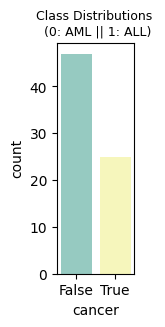

In [11]:
plt.figure(figsize=(1,3))
colors = ["ALL", "AML"]
sns.countplot(x='cancer', data=Data, palette = "Set3")
plt.title('Class Distributions \n (0: AML || 1: ALL)', fontsize=9)

In [13]:
num_rows, num_columns = Data.shape
print("Number of rows:", num_rows)
print("Number of columns:", num_columns)

Number of rows: 72
Number of columns: 7131


In [6]:
#The independent variables (features) are the inputs to the machine learning model.
#They are used to predict or estimate the dependent variable (target).
#(target) is the variable that the machine learning model aims to predict or classify.
#This separation allows us to easily pass the independent variables and dependent variable
#to machine learning algorithms for training and evaluation.
X, y = Data.drop(columns=["cancer"]), Data["cancer"] # dop the column cancer and stor in y dataframe
X.head()


,0,1,2,3,4,5,6,7,8,9,...,7120,7121,7122,7123,7124,7125,7126,7127,7128,patient
0,-214,-153,-58,88,-295,-558,199,-176,252,206,...,511,-125,389,-37,793,329,36,191,-37,1
1,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,837,-36,442,-17,782,295,11,76,-14,2
2,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,1199,33,168,52,1138,777,41,228,-41,3
3,-135,-114,265,12,-419,-585,158,-253,49,31,...,835,218,174,-110,627,170,-50,126,-91,4
4,-106,-125,-76,168,-230,-284,4,-122,70,252,...,649,57,504,-26,250,314,14,56,-25,5


In [15]:
y.head()

0    False
1    False
2    False
3    False
4    False
Name: cancer, dtype: bool

# ***FEATURE ENGINEERING***

# ***PCA***

Enter the test size (e.g., 0.2 for 20%):  0.30


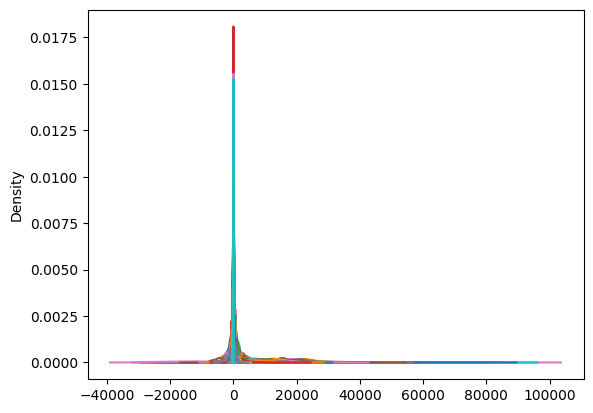

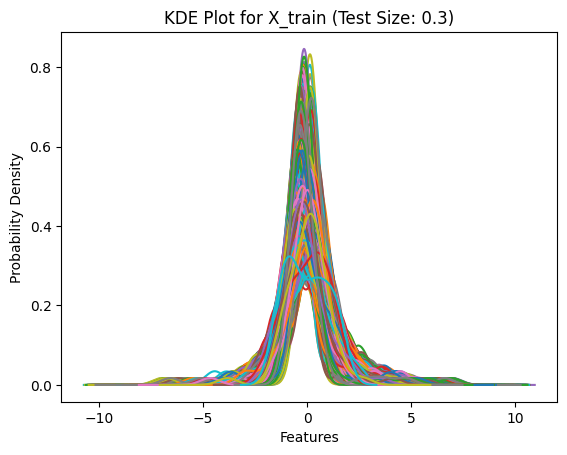

36 features explain around 90% of the variance. From 7129 features to 36, not too bad.


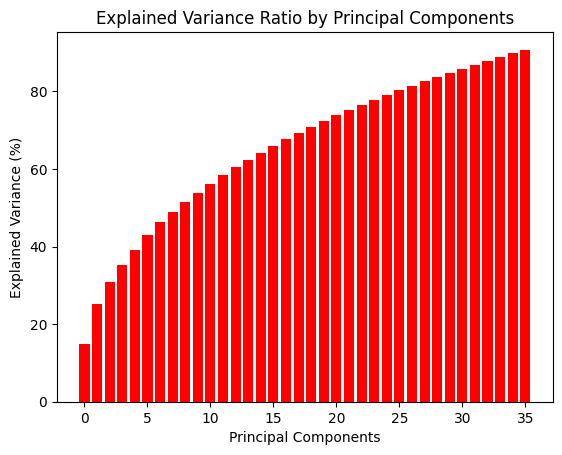

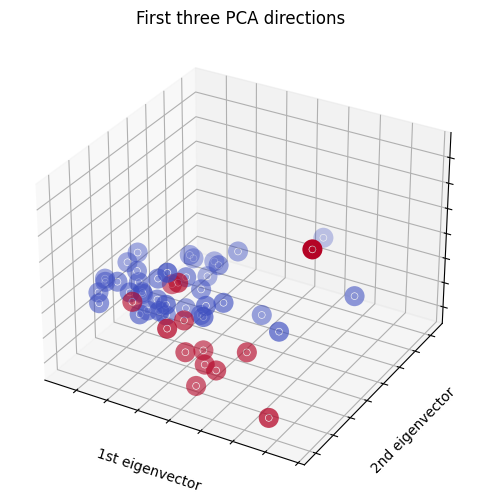

In [7]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

output_dir = "/kaggle/working/"
test_sizes = [0.05,0.10,0.15,0.20,0.25, 0.30,0.35, 0.40,0.45, 0.50,0.55, 0.60,0.65]

def create_kde_plot_and_pca(test_size, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)
    X_train.columns = X_train.columns.astype(str)
    X_test.columns = X_test.columns.astype(str)
    X_train = pd.DataFrame(X_train)
    X_train.plot(kind="kde", legend=None)  
    X_train_scaled = StandardScaler().fit_transform(X_train)
    X_test_scaled = StandardScaler().fit_transform(X_test)
    X_train_scaled = pd.DataFrame(X_train_scaled)
    kde_plot_after = X_train_scaled.plot(kind="kde", legend=None)
    plt.title(f"KDE Plot for X_train (Test Size: {test_size})")
    plt.xlabel("Features")
    plt.ylabel("Probability Density")
    plt.show()
    # Perform PCA
    pca = PCA()
    pca.fit_transform(X_train_scaled)
    total = sum(pca.explained_variance_)
    k = 0
    current_variance = 0
    while current_variance/total < 0.90:
        current_variance += pca.explained_variance_[k]
        k = k + 1
    print(k, " features explain around 90% of the variance. From 7129 features to ", k, ", not too bad.", sep='')
    pca = PCA(n_components=k)
    X_train_pca = pca.fit(X_train_scaled)
    X_train_pca = pca.transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    var_exp = pca.explained_variance_ratio_.cumsum()
    var_exp = var_exp*100
    plt.bar(range(k), var_exp,color = 'r')
    plt.title("Explained Variance Ratio by Principal Components")
    plt.xlabel("Principal Components")
    plt.ylabel("Explained Variance (%)")
    plt.show()
    pca3 = PCA(n_components=3).fit(X_train_scaled)
    X_train_reduced = pca3.transform(X_train_scaled)
    fig = plt.figure(figsize=(10, 6))  # Create the figure
    ax = fig.add_subplot(111, projection='3d')  # Add 3D subplot to the figure
    ax.scatter(X_train_reduced[:, 0], X_train_reduced[:, 1], X_train_reduced[:, 2], c=y_train, cmap='coolwarm', linewidths=10)
    ax.set_title("First three PCA directions")
    ax.set_xlabel("1st eigenvector")
    ax.set_ylabel("2nd eigenvector")
    ax.set_zlabel("3rd eigenvector")
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.zaxis.set_ticklabels([])
    plt.show()
    return X_train_pca, X_test_pca, y_train, y_test

test_size_input = float(input("Enter the test size (e.g., 0.2 for 20%): "))
#if input is valid or not 
if test_size_input in test_sizes:
    X_train_pca, X_test_pca, y_train, y_test = create_kde_plot_and_pca(test_size_input, X, y)
else:
    print("Invalid test size. Please enter a valid test size from the provided list.")







The StandardScaler is used to standardize features by removing the mean and scaling them to unit variance. This preprocessing step is crucial in many machine learning algorithms because it ensures that all features have the same scale.

Without scaling, features with larger scales can dominate the learning process, leading to biased models. Standardizing the features ensures that each feature contributes equally to the learning process, preventing any single feature from having undue influence on the model.

In the context of the provided code, the StandardScaler is applied to the training and test data before plotting the KDE plots. This ensures that the data is standardized and ready for analysis, allowing for fair comparisons between different features.




One effective technique to improve the performance of the code is to implement parallel processing using Python's multiprocessing module. This approach allows you to distribute the workload across multiple CPU cores, which can significantly reduce the overall processing time, especially for CPU-bound tasks like plotting multiple plots.

This line of code initializes the PCA (Principal Component Analysis) object with a specified parameter `n_components=0.90`. 

The `n_components` parameter determines the number of principal components to retain. In this case, `n_components=0.90` means that PCA will retain as many principal components as needed to explain 90% of the variance in the data.

By specifying `n_components=0.90`, PCA will automatically calculate the number of principal components required to explain 90% of the variance in the data and select those components. This is a common practice in PCA analysis as it helps reduce the dimensionality of the dataset while retaining most of the important information.

If you change the `n_components` parameter to a different value, PCA will select a different number of principal components. For example, setting `n_components=2` would force PCA to select only 2 principal components regardless of the amount of variance they explain. This may result in a loss of information if those 2 components do not adequately represent the data. 

In summary, adjusting the `n_components` parameter allows you to control the trade-off between dimensionality reduction and information retention in PCA analysis.

# ***BALANCING THE LABELS USING SMOTE***


In [86]:
from sklearn.utils import resample
from collections import Counter
from imblearn.over_sampling import SMOTE

print("Before Upsampling:-")
print(Counter(y_train))
oversample = SMOTE()
X_train_ov, y_train_ov = oversample.fit_resample(X_train_pca, y_train)
print("After Upsampling:-")
print(Counter(y_train_ov))


Before Upsampling:-
Counter({False: 19, True: 6})
After Upsampling:-
Counter({False: 19, True: 19})


Performing SMOTE (Synthetic Minority Over-sampling Technique) after PCA (Principal Component Analysis) can be beneficial in certain scenarios, depending on the nature of your data and the specific problem you're addressing. Here's why SMOTE is typically applied after PCA:

1. **Data Balancing**: SMOTE is often used to address class imbalance issues by oversampling the minority class. Imbalance in classes can lead to biased models that favor the majority class. However, applying SMOTE before PCA may lead to oversampling in the original feature space, which can affect the distribution of the data and potentially distort the principal components. By applying SMOTE after PCA, you're oversampling in the reduced feature space, which may preserve the structure of the data better.

2. **Dimensionality Reduction**: PCA reduces the dimensionality of the data by transforming it into a lower-dimensional space while retaining most of its variance. This transformation can help in reducing noise and focusing on the most important features. When oversampling is performed after PCA, the synthetic samples are generated in this reduced feature space, potentially leading to more meaningful and less noisy synthetic samples.

3. **Computational Efficiency**: PCA reduces the number of features in the dataset, which can lead to computational efficiency gains, especially when dealing with high-dimensional data. Performing SMOTE in the reduced feature space can be computationally cheaper compared to applying it on the original high-dimensional data.

However, it's essential to note that the choice of when to apply SMOTE depends on the specific characteristics of your dataset and the goals of your analysis. In some cases, it might be more appropriate to apply SMOTE before PCA, especially if the class imbalance is severe and the dataset is relatively small. Experimentation and empirical validation are crucial to determine the best approach for your particular problem.

**ISSSUES:**
The error message indicates that there is an issue with the number of neighbors specified for the k-nearest neighbors (KNN) algorithm used in the SMOTE (Synthetic Minority Over-sampling Technique) resampling process.

SMOTE is trying to find the k-nearest neighbors for each sample in the minority class, but it seems that the number of neighbors specified is greater than the number of samples available in the minority class.

To fix this issue, you need to ensure that the number of neighbors specified for SMOTE (`n_neighbors` parameter) is less than or equal to the number of samples in the minority class.


In this example, I've set the number of neighbors to 3, but you can adjust this value based on your specific dataset and requirements. Just ensure that it is less than or equal to the number of samples in the minority class to avoid the ValueError.

# ***OPTIMIZATION OF SVM MODEL***

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best Parameters: {'C': 1, 'kernel': 'linear'}
The accuracy of SVM is 0.7446808510638298

Classification report :
               precision    recall  f1-score   support

       False       0.70      1.00      0.82        28
        True       1.00      0.37      0.54        19

    accuracy                           0.74        47
   macro avg       0.85      0.68      0.68        47
weighted avg       0.82      0.74      0.71        47



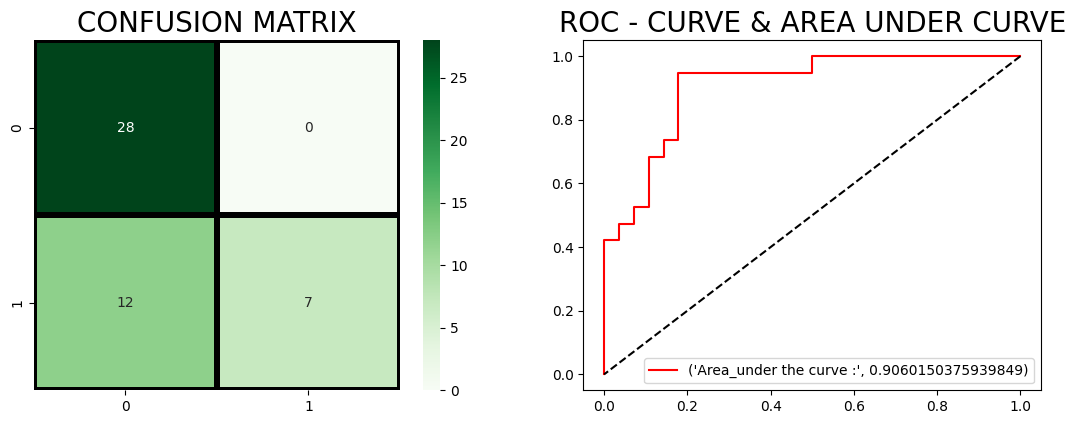

In [87]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os

output_dir = "/kaggle/working/"
accuracy_csv = "/kaggle/working/accuracy_results.csv"
def train_svm_and_save_results(X_train_ov, y_train_ov, X_test_pca, y_test, test_size_input):
    svc_params = [{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                  {'C': [1, 10, 100, 1000], 'kernel': ['rbf'], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}]

    search = GridSearchCV(SVC(), svc_params, n_jobs=-1, verbose=1)
    search.fit(X_train_ov, y_train_ov)
    best_accuracy = search.best_score_  
    best_parameters = search.best_params_  
    best_svc = search.best_estimator_
    print("Best Parameters:", best_parameters)
    svc_model = SVC(**best_parameters, probability=True)
    svc_model.fit(X_train_ov, y_train_ov)
    prediction = svc_model.predict(X_test_pca)
    acc_svc = accuracy_score(prediction, y_test)
    print('The accuracy of SVM is', acc_svc)
    print("\nClassification report :\n", classification_report(y_test, prediction))
    plt.figure(figsize=(13, 10))
    plt.subplot(221)
    sns.heatmap(confusion_matrix(y_test, prediction), annot=True, cmap='Greens', fmt="d", linecolor="k",
                linewidths=3)
    plt.title("CONFUSION MATRIX", fontsize=20)
    predicting_probabilites = svc_model.predict_proba(X_test_pca)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, predicting_probabilites)
    plt.subplot(222)
    plt.plot(fpr, tpr, label=("Area_under the curve :", auc(fpr, tpr)), color="r")
    plt.plot([1, 0], [1, 0], linestyle="dashed", color="k")
    plt.legend(loc="best")
    plt.title("ROC - CURVE & AREA UNDER CURVE", fontsize=20)
    accuracy_results = {'Test_Size': test_size_input, 'Accuracy': acc_svc}
    df_accuracy = pd.DataFrame(accuracy_results, index=[0])
    if os.path.exists(accuracy_csv):
        df_accuracy.to_csv(accuracy_csv, mode='a', header=False, index=False)
    else:
        df_accuracy.to_csv(accuracy_csv, index=False)
    return acc_svc
acc_svc=train_svm_and_save_results(X_train_ov, y_train_ov, X_test_pca, y_test, test_size_input)



# ***OPTIMIZATION OF LOGISTIC REGRESSION***

Validation accuracy of Logistic Regression is 0.7021276595744681

Classification report :
               precision    recall  f1-score   support

       False       0.77      0.71      0.74        28
        True       0.62      0.68      0.65        19

    accuracy                           0.70        47
   macro avg       0.69      0.70      0.70        47
weighted avg       0.71      0.70      0.70        47



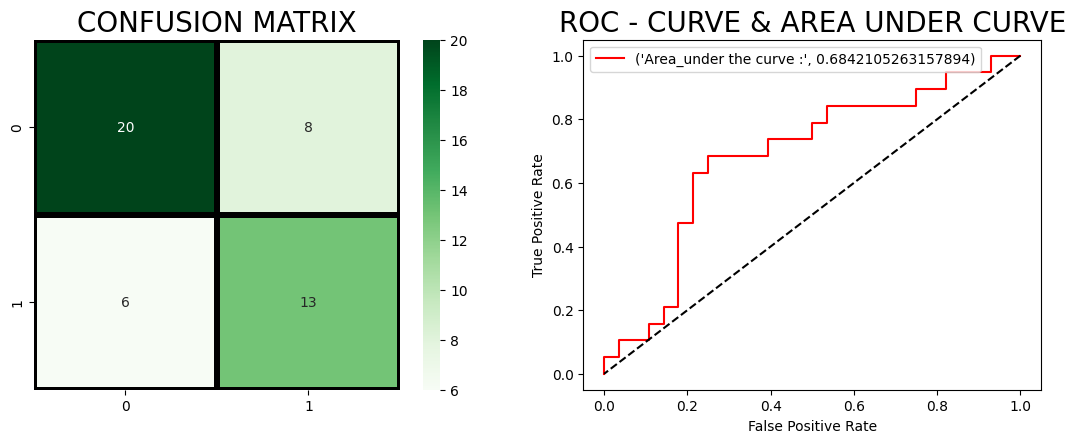

In [88]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
output_dir = "/kaggle/working/"
accuracy_csv2 = "/kaggle/working/accuracy_results2.csv"
log_grid = {'C': [1e-03, 1e-2, 1e-1, 1, 10], 'penalty': ['l1', 'l2']}
log_model = GridSearchCV(estimator=LogisticRegression(solver='liblinear'), 
                         param_grid=log_grid, 
                         cv=3,
                         scoring='accuracy')
log_model.fit(X_train_ov, y_train_ov)
best_accuracy = log_model.best_score_ 
best_parameters = log_model.best_params_  
best_lr = log_model.best_estimator_
lr_model = LogisticRegression(**best_parameters, solver='liblinear')
lr_model.fit(X_train_ov, y_train_ov)
prediction = lr_model.predict(X_test_pca)
acc_log = accuracy_score(prediction, y_test)
print('Validation accuracy of Logistic Regression is', acc_log)
print("\nClassification report :\n", classification_report(y_test, prediction))
plt.figure(figsize=(13, 10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test, prediction), annot=True, cmap="Greens", fmt="d", linecolor="k", linewidths=3)
plt.title("CONFUSION MATRIX", fontsize=20)
predicting_probabilites = lr_model.predict_proba(X_test_pca)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, predicting_probabilites)
plt.subplot(222)
plt.plot(fpr, tpr, label=("Area_under the curve :", auc(fpr, tpr)), color="r")
plt.plot([1, 0], [1, 0], linestyle="dashed", color="k")
plt.legend(loc="best")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC - CURVE & AREA UNDER CURVE", fontsize=20)
accuracy_results2 = {'Test_Size': test_size_input, 'Accuracy': acc_log}
df_accuracy2 = pd.DataFrame(accuracy_results2, index=[0])
if os.path.exists(accuracy_csv2):
    df_accuracy2.to_csv(accuracy_csv2, mode='a', header=False, index=False)
else:
    df_accuracy2.to_csv(accuracy_csv2, index=False)


# ***OPTIMIZATION OF NAIVE BAYES***

Validation accuracy of Naive Bayes is 0.723404255319149

Classification report :
               precision    recall  f1-score   support

       False       1.00      0.54      0.70        28
        True       0.59      1.00      0.75        19

    accuracy                           0.72        47
   macro avg       0.80      0.77      0.72        47
weighted avg       0.84      0.72      0.72        47



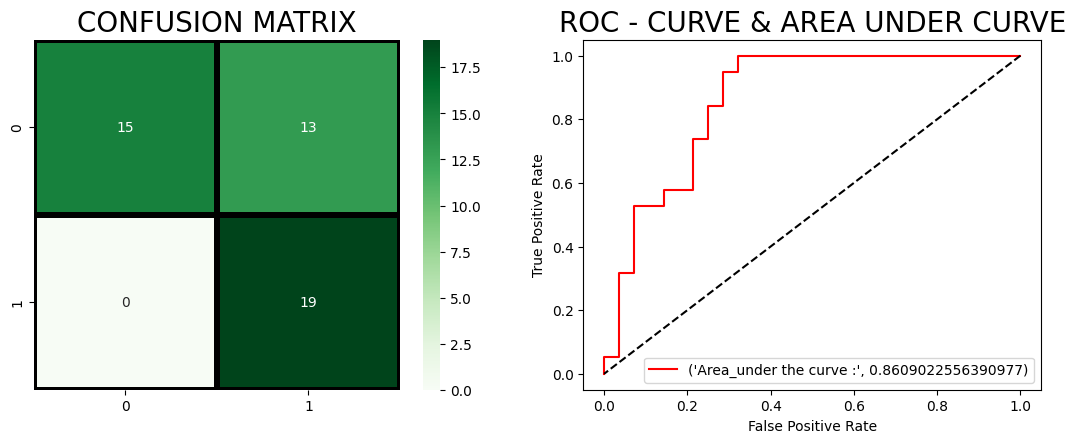

In [89]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
accuracy_csv3 = "/kaggle/working/accuracy_results3.csv"
nb_model = GaussianNB()
nb_model.fit(X_train_ov, y_train_ov)
prediction = nb_model.predict(X_test_pca)
acc_nb = accuracy_score(prediction, y_test)
print('Validation accuracy of Naive Bayes is', acc_nb)
print("\nClassification report :\n", classification_report(y_test, prediction))
plt.figure(figsize=(13, 10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test, prediction), annot=True, cmap="Greens", fmt="d", linecolor="k", linewidths=3)
plt.title("CONFUSION MATRIX", fontsize=20)
predicting_probabilites = nb_model.predict_proba(X_test_pca)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, predicting_probabilites)
plt.subplot(222)
plt.plot(fpr, tpr, label=("Area_under the curve :", auc(fpr, tpr)), color="r")
plt.plot([1, 0], [1, 0], linestyle="dashed", color="k")
plt.legend(loc="best")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC - CURVE & AREA UNDER CURVE", fontsize=20)
accuracy_results3 = {'Test_Size': test_size_input, 'Accuracy': acc_nb}
df_accuracy3 = pd.DataFrame(accuracy_results3, index=[0])
if os.path.exists(accuracy_csv3):
    df_accuracy3.to_csv(accuracy_csv3, mode='a', header=False, index=False)
else:
    df_accuracy3.to_csv(accuracy_csv3, index=False)


In [39]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines','Logistic Regression','Naive Bayes'],
    'Score': [acc_svc, acc_log,  acc_nb]})
models.sort_values(by='Score', ascending=False)

,Model,Score
1,Logistic Regression,1.000000
0,Support Vector Machines,0.727273
2,Naive Bayes,0.636364


# ***COMPARE PERFORMANCE USING T-TEST***

SVM vs. Logistic Regression: t-statistic = -2.7137119967572434 p-value = 0.018825627730358133
SVM vs. Naive Bayes: t-statistic = 0.9017081384209522 p-value = 0.38495307219756514
Logistic Regression vs. Naive Bayes: t-statistic = 3.3861233381597144 p-value = 0.005406607536604673


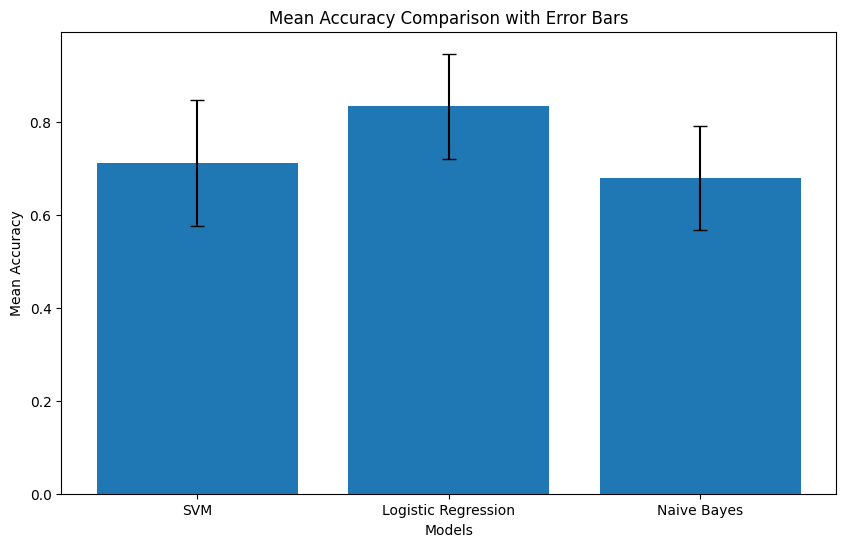

In [90]:
import pandas as pd
from scipy.stats import ttest_rel
svm_results = pd.read_csv("accuracy_results.csv")
lr_results = pd.read_csv("accuracy_results2.csv")
nb_results = pd.read_csv("accuracy_results3.csv")
min_length = min(len(svm_results), len(lr_results), len(nb_results))
svm_results = svm_results.head(min_length)
lr_results = lr_results.head(min_length)
nb_results = nb_results.head(min_length)
t_statistic_svm_lr, p_value_svm_lr = ttest_rel(svm_results['Accuracy'], lr_results['Accuracy'])
t_statistic_svm_nb, p_value_svm_nb = ttest_rel(svm_results['Accuracy'], nb_results['Accuracy'])
t_statistic_lr_nb, p_value_lr_nb = ttest_rel(lr_results['Accuracy'], nb_results['Accuracy'])
print("SVM vs. Logistic Regression: t-statistic =", t_statistic_svm_lr, "p-value =", p_value_svm_lr)
print("SVM vs. Naive Bayes: t-statistic =", t_statistic_svm_nb, "p-value =", p_value_svm_nb)
print("Logistic Regression vs. Naive Bayes: t-statistic =", t_statistic_lr_nb, "p-value =", p_value_lr_nb)
plt.figure(figsize=(10, 6))
models = ['SVM', 'Logistic Regression', 'Naive Bayes']
means = [svm_results['Accuracy'].mean(), lr_results['Accuracy'].mean(), nb_results['Accuracy'].mean()]
stds = [svm_results['Accuracy'].std(), lr_results['Accuracy'].std(), nb_results['Accuracy'].std()]
plt.bar(models, means, yerr=stds, capsize=5)
plt.title('Mean Accuracy Comparison with Error Bars')
plt.xlabel('Models')
plt.ylabel('Mean Accuracy')
plt.show()

After performing a t-test, the results of the bar plot would essentially confirm or reject the null hypothesis that there is no significant difference between the mean accuracies of the models being compared. 

If the p-value from the t-test is less than a chosen significance level (e.g., 0.05), it suggests that there is enough evidence to reject the null hypothesis, indicating that there is a statistically significant difference between the mean accuracies of the models. In this case, the bar plot would visually demonstrate these differences.

On the other hand, if the p-value is greater than the significance level, it suggests that there is insufficient evidence to reject the null hypothesis, indicating that there is no statistically significant difference between the mean accuracies of the models. In this scenario, the bar plot would not show any visually apparent differences between the means.

Therefore, the results of the bar plot, along with the t-test results, would help in determining whether there are significant differences in the mean accuracies of the models being compared.

Bar Heights: The heights of the bars representing the mean accuracies of the models would be visibly different. The bar corresponding to the model with higher accuracy would be taller than the others, indicating better performance.

Error Bars: If you included error bars in the bar plot, they would show the uncertainty associated with each mean accuracy estimate. If the error bars do not overlap between models, it further supports the evidence of significant differences in accuracies.

Statistical Significance: The t-test results would confirm the observed differences. A significant p-value (typically < 0.05) would indicate that the observed difference in mean accuracies is unlikely to have occurred due to random chance alone, providing statistical evidence of a true difference between the models.

# ***COMPARE PERFORMANCE USING ANOVA TEST***

ANOVA Test Results:
F-Statistic: 5.852595210533871
p-value: 0.006298883945470246


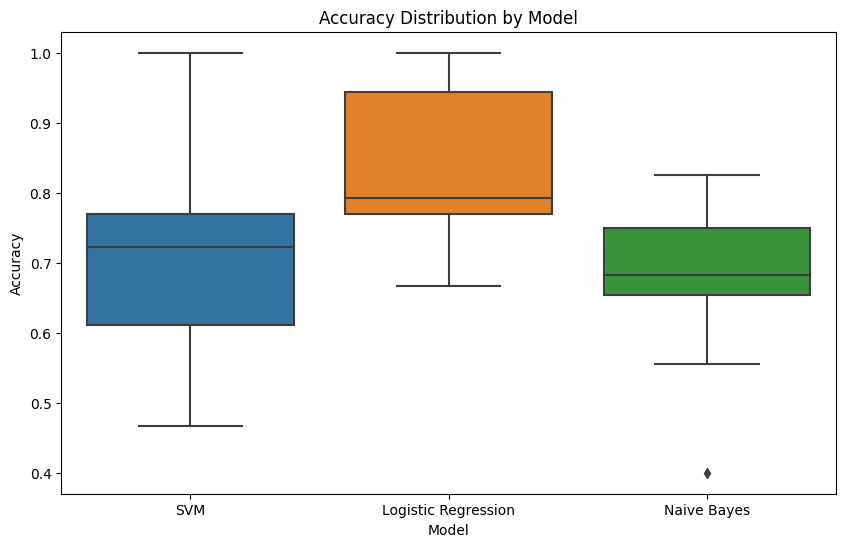

In [91]:
import pandas as pd
from scipy.stats import f_oneway
import matplotlib.pyplot as plt
import seaborn as sns
svm_results = pd.read_csv("accuracy_results.csv")
lr_results = pd.read_csv("accuracy_results2.csv")
nb_results = pd.read_csv("accuracy_results3.csv")
min_length = min(len(svm_results), len(lr_results), len(nb_results))
svm_results = svm_results.head(min_length)
lr_results = lr_results.head(min_length)
nb_results = nb_results.head(min_length)
f_statistic, p_value = f_oneway(svm_results['Accuracy'], lr_results['Accuracy'], nb_results['Accuracy'])
print("ANOVA Test Results:")
print("F-Statistic:", f_statistic)
print("p-value:", p_value)
data = pd.concat([svm_results['Accuracy'], lr_results['Accuracy'], nb_results['Accuracy']], axis=1)
data.columns = ['SVM', 'Logistic Regression', 'Naive Bayes']
plt.figure(figsize=(10, 6))
sns.boxplot(data=data)
plt.title('Accuracy Distribution by Model')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.show()
